### This uses PyCaret to test different models on the dataset.

In [1]:
import seaborn as sns
import pandas as pd

A function for examining model metrics

Read in the dataset.

In [2]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/scaled_and_noise_removal.csv")
#pivoted_df = pd.read_csv("../../data/Unscaled_Baseline_Correction.csv")
#pivoted_df = pd.read_csv("../../data/Scaled_Baseline_Correction.csv")
df = pd.read_csv("../../data/current_clean_spectrum.csv")
#df = pd.read_csv("../../data/scaling_test.csv")

In [3]:
# fastRP_df = pd.read_csv("../../data/fastRP_embeddings.csv")
# statuses_df = pd.read_csv("../../data/SpecIDs_and_Status.csv")
# pivoted_df = fastRP_df.merge(statuses_df, on="SpecID").sort_values(by="SpecID").set_index('SpecID')

In [4]:
df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,32.316184
1,201210-1-00,294,400.91116,201210-1,Normal,32.229535
2,201210-1-00,295,401.59454,201210-1,Normal,32.142799
3,201210-1-00,296,402.27789,201210-1,Normal,32.055975
4,201210-1-00,297,402.96127,201210-1,Normal,31.969064


In [5]:
sample = df[df['SpecID'] == "210526-3-15"]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

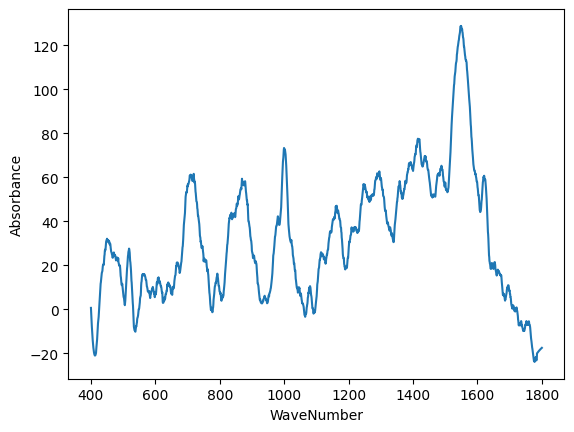

In [6]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [7]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

Pivot the Dataframe to create a column for each wavelength

In [8]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [9]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,32.316184,32.229535,32.142799,32.055975,31.969064,31.882065,31.794978,31.707804,31.620543,31.533194,...,-12.723337,-13.540514,-14.403567,-15.312496,-16.267300,-17.267980,-18.314536,-19.406968,201210-1,Normal
201210-1-01,39.811601,40.877763,41.908020,42.902373,43.860821,44.783365,45.670004,46.520739,47.335569,48.114495,...,-13.672706,-13.392564,-13.087568,-12.757716,-12.403010,-12.023449,-11.619033,-11.189762,201210-1,Normal
201210-1-02,127.402498,126.208880,125.072470,123.993266,122.971270,122.006480,121.098897,120.248520,119.455351,118.719388,...,-34.637995,-34.921717,-35.192205,-35.449460,-35.693482,-35.924271,-36.141826,-36.346148,201210-1,Normal
201210-1-03,238.275614,236.190042,234.192478,232.282921,230.461371,228.727828,227.082293,225.524765,224.055244,222.673731,...,-59.464156,-58.989926,-58.455958,-57.862252,-57.208808,-56.495627,-55.722707,-54.890050,201210-1,Normal
201210-1-04,130.259565,127.367142,124.602820,121.966600,119.458481,117.078463,114.826546,112.702731,110.707016,108.839403,...,-58.361520,-59.039705,-59.726043,-60.420534,-61.123178,-61.833975,-62.552925,-63.280028,201210-1,Normal


##### PyCaret

In [10]:
import pandas as pd
from pycaret.classification import *

Set up the PyCaret environment

**Use GroupKFold to ensure that spectra from the same Surface are not used in both the training and testing folds.**

In [11]:
caret = setup(data=wavelength_df, target='Status', session_id=1234, fold_strategy='groupkfold', fold_groups='SurID')

,Description,Value
0,Session id,1234
1,Target,Status
2,Target type,Multiclass
3,Target mapping,"Hyperglycemia: 0, Hypoglycemia: 1, Normal: 2"
4,Original data shape,"(3045, 2051)"
5,Transformed data shape,"(3045, 2051)"
6,Transformed train set shape,"(2131, 2051)"
7,Transformed test set shape,"(914, 2051)"
8,Numeric features,2049
9,Categorical features,1


Compare models

In [12]:
#compare_models(exclude=['lightgbm', 'gbc'])
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5707,0.0000,0.5707,0.6771,0.5867,0.3274,0.3533,0.9670
et,Extra Trees Classifier,0.5477,0.0000,0.5477,0.6613,0.5613,0.3017,0.3265,0.6630
knn,K Neighbors Classifier,0.5079,0.0000,0.5079,0.6089,0.5263,0.2275,0.2451,0.4970
lr,Logistic Regression,0.5023,0.0000,0.5023,0.6514,0.5362,0.2488,0.2755,8.0110
svm,SVM - Linear Kernel,0.4334,0.0000,0.4334,0.5708,0.4283,0.1412,0.1697,0.5420
nb,Naive Bayes,0.4080,0.0000,0.4080,0.5861,0.3754,0.1159,0.1522,0.4340
ridge,Ridge Classifier,0.3634,0.0000,0.3634,0.4939,0.3894,0.0692,0.0762,0.5230
dt,Decision Tree Classifier,0.3495,0.0000,0.3495,0.1426,0.1984,0.0000,0.0000,0.5020
ada,Ada Boost Classifier,0.3495,0.0000,0.3495,0.1426,0.1984,0.0000,0.0000,3.3240
gbc,Gradient Boosting Classifier,0.3495,0.0000,0.3495,0.1426,0.1984,0.0000,0.0000,24.0310


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

Create the model

In [16]:
model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4171,0.0000,0.4171,0.4627,0.4030,0.1477,0.1602
1,0.5829,0.0000,0.5829,0.6857,0.6243,0.2669,0.2785
2,0.4045,0.0000,0.4045,0.5134,0.4004,0.1671,0.1941
3,0.5648,0.0000,0.5648,0.7112,0.5436,0.2443,0.2962
4,0.5498,0.0000,0.5498,0.7502,0.6336,0.2468,0.2758
5,0.7441,0.0000,0.7441,0.7435,0.7422,0.6144,0.6156
6,0.5545,0.0000,0.5545,0.5974,0.5476,0.3288,0.3466
7,0.7752,0.0000,0.7752,0.8683,0.8061,0.6275,0.6457
8,0.5355,0.0000,0.5355,0.5994,0.5518,0.2974,0.3103


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
#tuned_model = tune_model(model)
tuned_model = tune_model(model, n_iter=250, search_library='optuna')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:28:40
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-03-14 18:28:40,539] Searching the best hyperparameters using 2131 samples...


In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…